In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
import contextily as ctx

from asp_plot.jitter import read_linescan_csm_cam, read_angles

In [2]:
before1 = "../tests/test_data/jitter/csm-10300100A0D00200.r100.adjusted_state.json"
before2 = "../tests/test_data/jitter/csm-10300100A15E3900.r100.adjusted_state.json"
after1 = "../tests/test_data/jitter/jitter_solved_csm-10300100A0D00200.r100.adjusted_state.json"
after2 = "../tests/test_data/jitter/jitter_solved_csm-10300100A15E3900.r100.adjusted_state.json"

map_crs = "32728" # UTM 28S
# map_crs = "4326"

ctx_kwargs = {
    "crs": f"EPSG:{map_crs}",
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

In [3]:
# cam1, cam2 = before1, after1
cam1, cam2 = before2, after2

positions1, rotations1 = read_linescan_csm_cam(cam1)
positions2, rotations2 = read_linescan_csm_cam(cam2)

positions1 = np.array(positions1)
positions2 = np.array(positions2)
rotations1 = np.array(rotations1)
rotations2 = np.array(rotations2)

orig_rotation_angles, opt_rotation_angles = read_angles([cam1], [cam2], [])

orig_roll  = [r[0] for r in orig_rotation_angles]
orig_pitch = [r[1] for r in orig_rotation_angles]
orig_yaw   = [r[2] for r in orig_rotation_angles]
opt_roll   = [r[0] for r in opt_rotation_angles]
opt_pitch  = [r[1] for r in opt_rotation_angles]
opt_yaw    = [r[2] for r in opt_rotation_angles]

roll_diff = np.array(orig_roll) - np.array(opt_roll)
pitch_diff = np.array(orig_pitch) - np.array(opt_pitch)
yaw_diff = np.array(orig_yaw) - np.array(opt_yaw)

In [4]:
def reproject_ecef(positions, to_epsg=32604):
    transformer = Transformer.from_crs("EPSG:4978", f"EPSG:{to_epsg}")
    lons, lats, alts = transformer.transform(positions[:, 0], positions[:, 1], positions[:, 2])
    return np.column_stack((lons, lats, alts))

In [5]:
positions1_proj = reproject_ecef(positions1, to_epsg=map_crs)
positions2_proj = reproject_ecef(positions2, to_epsg=map_crs)

position_diffs = positions2_proj - positions1_proj
x_diff = position_diffs[:, 0]
y_diff = position_diffs[:, 1]
z_diff = position_diffs[:, 2]
position_diff_magnitudes = np.linalg.norm(position_diffs, axis=1)

data = {
    'position1': [Point(x, y, z) for x, y, z in positions1_proj],
    'position2': [Point(x, y, z) for x, y, z in positions2_proj],
    'rotation1': [r for r in rotations1],
    'rotation2': [r for r in rotations2],
    'position_diff_magnitude': position_diff_magnitudes,
    'x_diff': x_diff,
    'y_diff': y_diff,
    'z_diff': z_diff,
    'roll_diff': roll_diff,
    'pitch_diff': pitch_diff,
    'yaw_diff': yaw_diff,
}

df = pd.DataFrame(data)

gdf = gpd.GeoDataFrame(df, geometry='position1')

gdf.set_crs(epsg=map_crs, inplace=True)


,position1,position2,rotation1,rotation2,position_diff_magnitude,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff
0,POINT Z (535429.5 1067750.293 795131.635),POINT Z (535429.499856853 1067750.2927399948 7...,"[[-0.16241692496906107, 0.9295643588459488, 0....","[[-0.16241692496906107, 0.9295643588459488, 0....",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,POINT Z (535309.681 1067690.466 795131.685),POINT Z (535309.6810336593 1067690.4655358717 ...,"[[-0.16244050759520745, 0.9296102059963607, 0....","[[-0.16244050759520745, 0.9296102059963607, 0....",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,POINT Z (535189.862 1067630.638 795131.735),POINT Z (535189.8623937691 1067630.637999637 7...,"[[-0.16246408306115367, 0.9296560244668811, 0....","[[-0.16246408306115367, 0.9296560244668811, 0....",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,POINT Z (535070.044 1067570.81 795131.785),POINT Z (535070.0439373263 1067570.8101313487 ...,"[[-0.1624876514360345, 0.9297018142593526, 0.3...","[[-0.1624876514360345, 0.9297018142593527, 0.3...",0.000000e+00,0.0,0.0,0.000000e+00,-5.684342e-14,-1.065814e-14,-3.552714e-14
4,POINT Z (534950.226 1067510.982 795131.835),POINT Z (534950.2256642121 1067510.9819309115 ...,"[[-0.16251121272802505, 0.9297475753872376, 0....","[[-0.16251121272802505, 0.9297475753872377, 0....",0.000000e+00,0.0,0.0,0.000000e+00,-4.973799e-14,0.000000e+00,-2.842171e-14
...,...,...,...,...,...,...,...,...,...,...,...
1726,POINT Z (328868.732 963958.388 795190.519),POINT Z (328868.73208980303 963958.3878865242 ...,"[[-0.18409818941399647, 0.9775094528036894, 0....","[[-0.18409818941399647, 0.9775094528036893, 0....",1.862645e-09,0.0,0.0,1.862645e-09,-2.886580e-14,2.486900e-14,-7.105427e-15
1727,POINT Z (328749.184 963897.925 795190.537),POINT Z (328749.18400643277 963897.9249246009 ...,"[[-0.1840968411862951, 0.9775233690850222, 0.1...","[[-0.1840968411862951, 0.9775233690850222, 0.1...",0.000000e+00,0.0,0.0,0.000000e+00,1.374989e-11,-1.738982e-10,3.558398e-11
1728,POINT Z (328629.636 963837.462 795190.555),POINT Z (328629.63605421316 963837.4615574144 ...,"[[-0.1840954733346516, 0.9775372720848355, 0.1...","[[-0.1840954733346516, 0.9775372720848355, 0.1...",0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1729,POINT Z (328510.088 963776.998 795190.574),POINT Z (328510.08823302574 963776.9977848809 ...,"[[-0.18409408590980025, 0.9775511617915903, 0....","[[-0.18409408590980048, 0.9775511617915903, 0....",0.000000e+00,0.0,0.0,0.000000e+00,3.197442e-14,-4.973799e-14,2.131628e-14


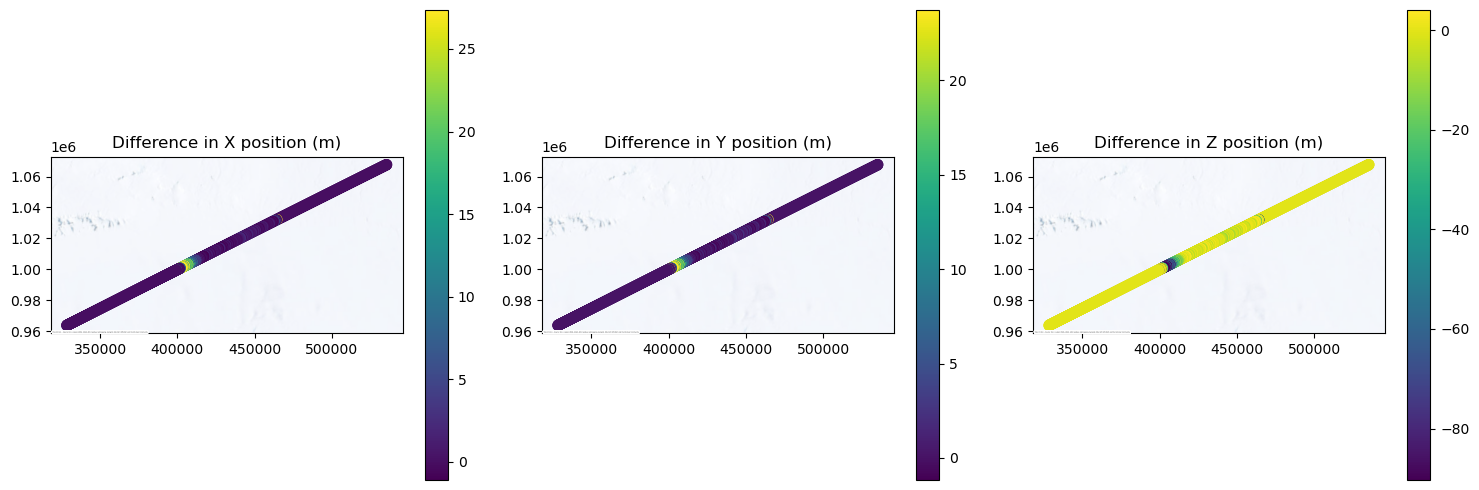

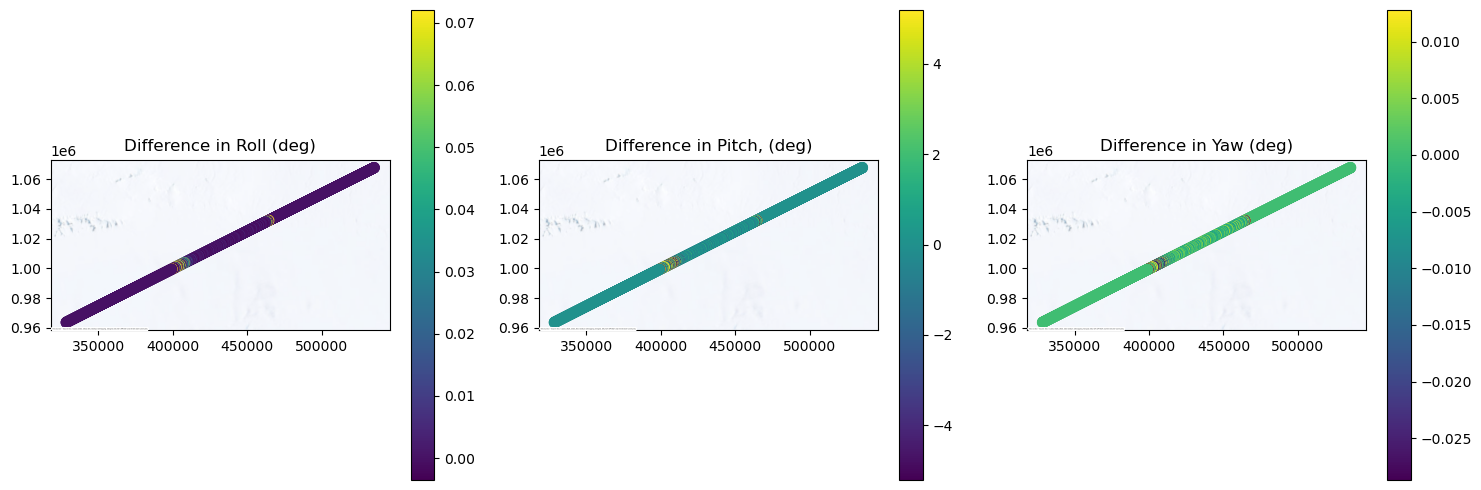

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gdf.plot(column='x_diff', cmap='viridis', markersize=50, legend=True, ax=axes[0], vmin=np.percentile(x_diff, 1), vmax=np.percentile(x_diff, 99))
axes[0].set_title('Difference in X position (m)')
ctx.add_basemap(ax=axes[0], **ctx_kwargs)

gdf.plot(column='y_diff', cmap='viridis', markersize=50, legend=True, ax=axes[1], vmin=np.percentile(y_diff, 1), vmax=np.percentile(y_diff, 99))
axes[1].set_title('Difference in Y position (m)')
ctx.add_basemap(ax=axes[1], **ctx_kwargs)

gdf.plot(column='z_diff', cmap='viridis', markersize=50, legend=True, ax=axes[2], vmin=np.percentile(z_diff, 1), vmax=np.percentile(z_diff, 99))
axes[2].set_title('Difference in Z position (m)')
ctx.add_basemap(ax=axes[2], **ctx_kwargs)

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gdf.plot(column='roll_diff', cmap='viridis', markersize=50, legend=True, ax=axes[0], vmin=np.percentile(roll_diff, 1), vmax=np.percentile(roll_diff, 99))
axes[0].set_title('Difference in Roll (deg)')
ctx.add_basemap(ax=axes[0], **ctx_kwargs)

gdf.plot(column='pitch_diff', cmap='viridis', markersize=50, legend=True, ax=axes[1], vmin=np.percentile(pitch_diff, 1), vmax=np.percentile(pitch_diff, 99))
axes[1].set_title('Difference in Pitch, (deg)')
ctx.add_basemap(ax=axes[1], **ctx_kwargs)

gdf.plot(column='yaw_diff', cmap='viridis', markersize=50, legend=True, ax=axes[2], vmin=np.percentile(yaw_diff, 1), vmax=np.percentile(yaw_diff, 99))
axes[2].set_title('Difference in Yaw (deg)')
ctx.add_basemap(ax=axes[2], **ctx_kwargs)

plt.tight_layout()
plt.show()

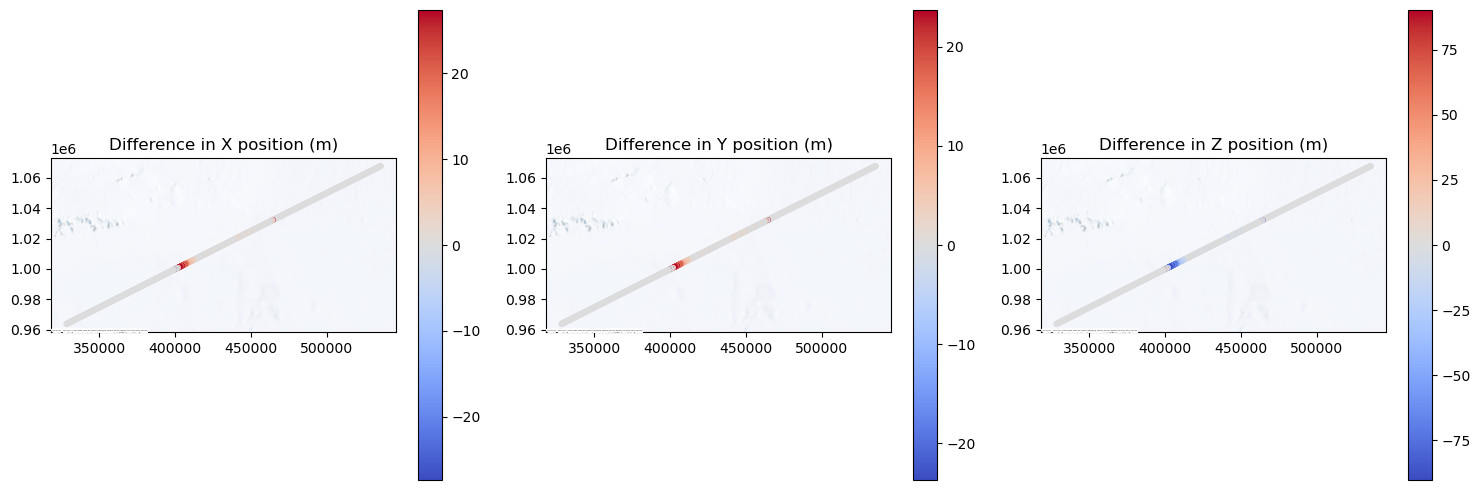

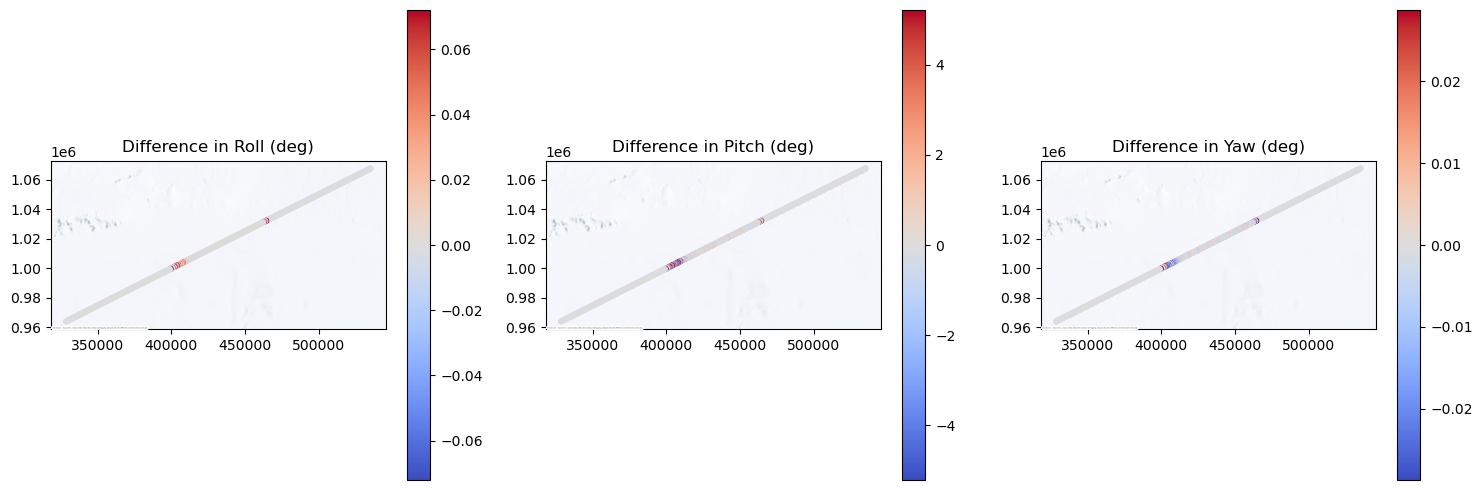

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the symmetric vmin and vmax for centering around 0
x_vmax = max(abs(np.percentile(x_diff, 1)), abs(np.percentile(x_diff, 99)))
y_vmax = max(abs(np.percentile(y_diff, 1)), abs(np.percentile(y_diff, 99)))
z_vmax = max(abs(np.percentile(z_diff, 1)), abs(np.percentile(z_diff, 99)))

gdf.plot(column='x_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[0], vmin=-x_vmax, vmax=x_vmax)
axes[0].set_title('Difference in X position (m)')
ctx.add_basemap(ax=axes[0], **ctx_kwargs)

gdf.plot(column='y_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[1], vmin=-y_vmax, vmax=y_vmax)
axes[1].set_title('Difference in Y position (m)')
ctx.add_basemap(ax=axes[1], **ctx_kwargs)

gdf.plot(column='z_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[2], vmin=-z_vmax, vmax=z_vmax)
axes[2].set_title('Difference in Z position (m)')
ctx.add_basemap(ax=axes[2], **ctx_kwargs)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the symmetric vmin and vmax for centering around 0
roll_vmax = max(abs(np.percentile(roll_diff, 1)), abs(np.percentile(roll_diff, 99)))
pitch_vmax = max(abs(np.percentile(pitch_diff, 1)), abs(np.percentile(pitch_diff, 99)))
yaw_vmax = max(abs(np.percentile(yaw_diff, 1)), abs(np.percentile(yaw_diff, 99)))

gdf.plot(column='roll_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[0], vmin=-roll_vmax, vmax=roll_vmax)
axes[0].set_title('Difference in Roll (deg)')
ctx.add_basemap(ax=axes[0], **ctx_kwargs)

gdf.plot(column='pitch_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[1], vmin=-pitch_vmax, vmax=pitch_vmax)
axes[1].set_title('Difference in Pitch (deg)')
ctx.add_basemap(ax=axes[1], **ctx_kwargs)

gdf.plot(column='yaw_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[2], vmin=-yaw_vmax, vmax=yaw_vmax)
axes[2].set_title('Difference in Yaw (deg)')
ctx.add_basemap(ax=axes[2], **ctx_kwargs)

plt.tight_layout()
plt.show()

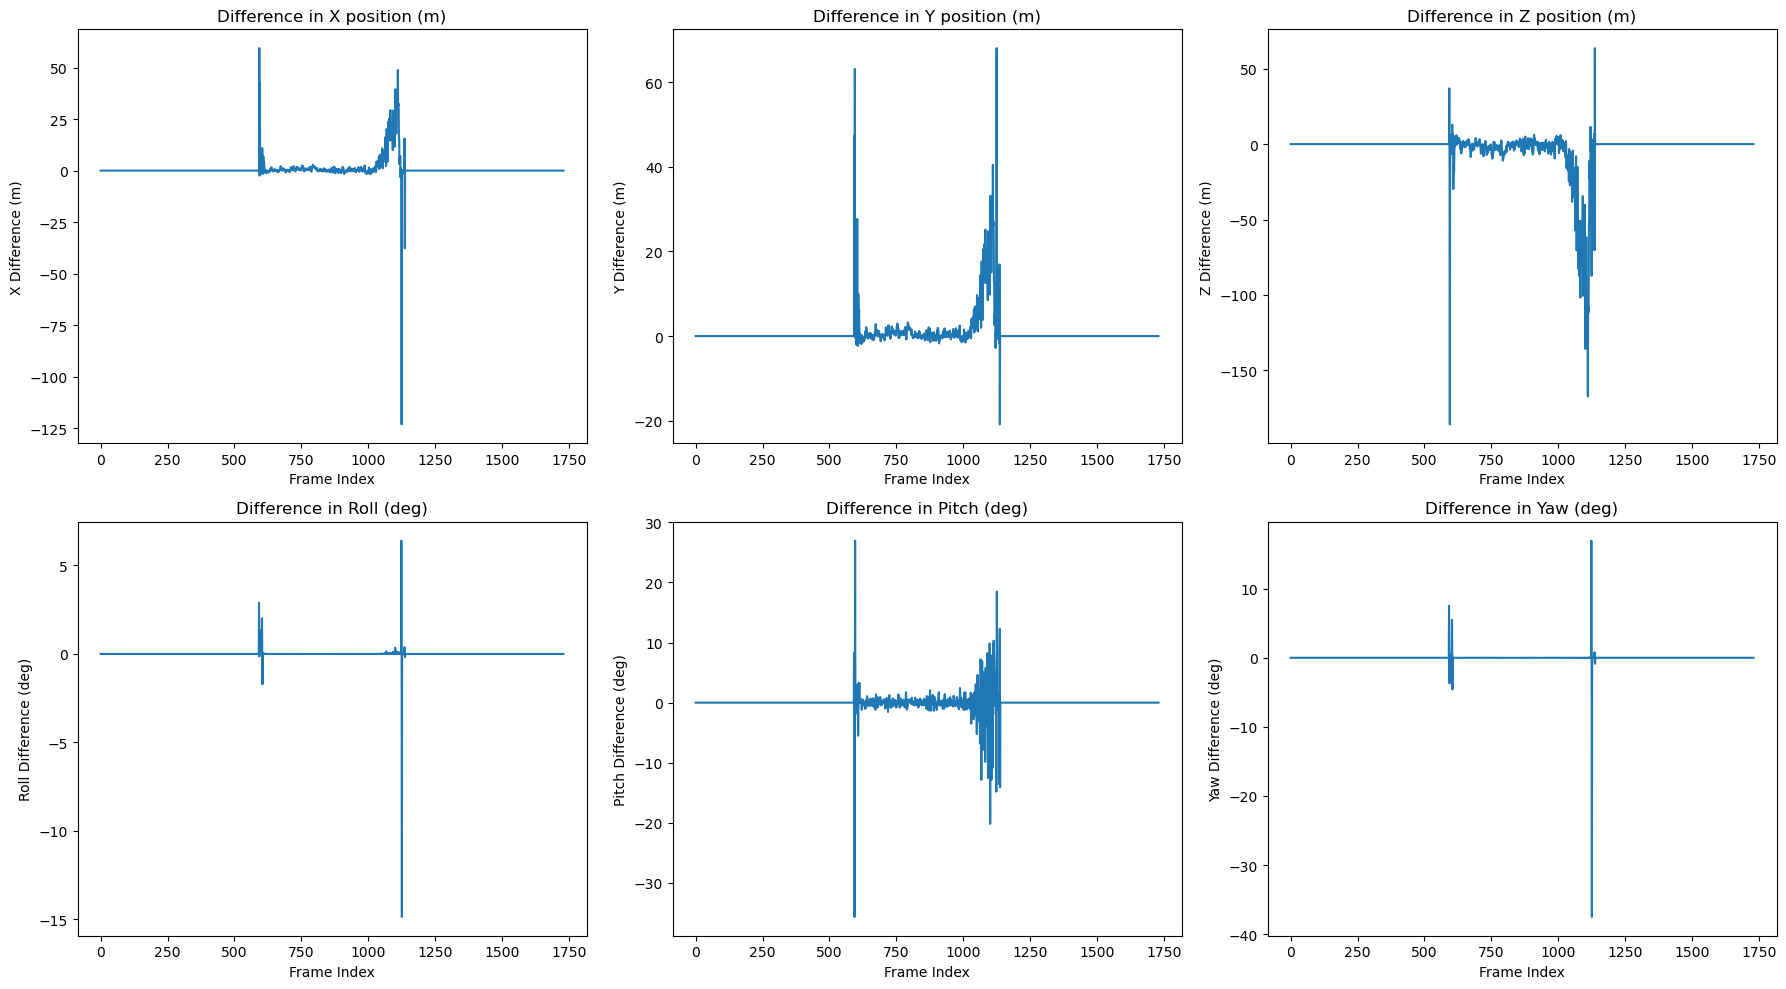

In [8]:
frame = np.arange(gdf.shape[0])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot differences in x, y, z
axes[0, 0].plot(frame, gdf["x_diff"])
axes[0, 0].set_title('Difference in X position (m)')
axes[0, 0].set_xlabel('Frame Index')
axes[0, 0].set_ylabel('X Difference (m)')

axes[0, 1].plot(frame, gdf["y_diff"])
axes[0, 1].set_title('Difference in Y position (m)')
axes[0, 1].set_xlabel('Frame Index')
axes[0, 1].set_ylabel('Y Difference (m)')

axes[0, 2].plot(frame, gdf["z_diff"])
axes[0, 2].set_title('Difference in Z position (m)')
axes[0, 2].set_xlabel('Frame Index')
axes[0, 2].set_ylabel('Z Difference (m)')

# Plot differences in roll, pitch, yaw
axes[1, 0].plot(frame, gdf["roll_diff"])
axes[1, 0].set_title('Difference in Roll (deg)')
axes[1, 0].set_xlabel('Frame Index')
axes[1, 0].set_ylabel('Roll Difference (deg)')

axes[1, 1].plot(frame, gdf["pitch_diff"])
axes[1, 1].set_title('Difference in Pitch (deg)')
axes[1, 1].set_xlabel('Frame Index')
axes[1, 1].set_ylabel('Pitch Difference (deg)')

axes[1, 2].plot(frame, gdf["yaw_diff"])
axes[1, 2].set_title('Difference in Yaw (deg)')
axes[1, 2].set_xlabel('Frame Index')
axes[1, 2].set_ylabel('Yaw Difference (deg)')

plt.tight_layout()
plt.show()